# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, we will use computer vision tools to identify lane lines on the road.  We will first develop our pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images).

Once we have the lanes detected, we will need to average and/or extrapolate the line segments we have detected to map out the full extent of the lane lines.  

The writeup.md file describes the pipeline in detail. The .yaml file lists out the dependencies required to finish this project. 

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**  The goal of this project is to piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once we have a working pipeline, try it out on the video stream below.
The tools at our disposal are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  One can also explore and try other techniques that are not presented in the project.
**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages for working with images and arrays

## Test Reading  in an Image

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Ideas for Lane Detection Pipeline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


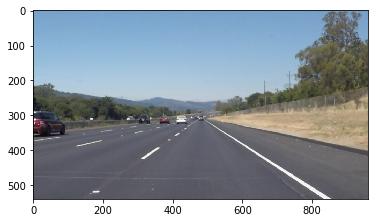

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions for various image processing operations using opencv

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math
# This function returns a grayscale image from a color image
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# This function detects edges in an image using gradients based on some thresholds and returns the edge image    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# This function blurs out the image using a gaussian kernel
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# This function defines a region of interest in an image as per vertices and returns the masked image 
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# This function draws lines of a given color and thickness on an image specified by a data array  
def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# This function calculates the hough lines from a given edge image and returns a blank image with the projected lines            
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

#This function is used to concatanate the left and right hough lines and project those on a blank image

def concatanate_hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, poly_height, color=[255, 0, 0], thickness=10):
    """
    `img` should be the output of a masking transform.
        
    Returns an image with concatanated hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #Sort the lane points into left and right lane
    r_lines_x=[]
    l_lines_x=[]
    r_lines_y=[]
    l_lines_y=[]    

    for line in lines:
          for x1,y1,x2,y2 in line:
                if x2 < 480:
                    l_lines_x.append(x1)
                    l_lines_x.append(x2)
                    l_lines_y.append(y1)
                    l_lines_y.append(y2)
                else:
                    r_lines_x.append(x1)
                    r_lines_x.append(x2)
                    r_lines_y.append(y1)
                    r_lines_y.append(y2)
                    
   
    #Find the slope and intercept of the best fit lines from these points
    left_slope, left_intercept = np.polyfit(l_lines_x, l_lines_y, 1) 
    right_slope, right_intercept = np.polyfit(r_lines_x, r_lines_y, 1) 
                    
    roi_y1 = img.shape[0]
    roi_y2 = poly_height
    
    right_x1 = (roi_y1 - right_intercept) / right_slope
    right_x2 = (roi_y2 - right_intercept) / right_slope
    
    left_x1 = (roi_y1 - left_intercept) / left_slope
    left_x2 = (roi_y2 - left_intercept) / left_slope  
    
    roi_y1 = int(roi_y1)
    roi_y2 = int(roi_y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
                
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)                     

    cv2.line(line_img, (left_x1, roi_y1), (left_x2, roi_y2), color, thickness)
    cv2.line(line_img, (right_x1, roi_y1), (right_x2, roi_y2), color, thickness)
        
    #cv2.line(line_img, (np.min(l_lines_x), np.max(l_lines_y)), (np.max(l_lines_x), np.min(l_lines_y)), [255, 0, 0], 10)
    #cv2.line(line_img, (np.min(r_lines_x), np.min(r_lines_y)), (np.max(r_lines_x), np.max(r_lines_y)), [255, 0, 0], 10)
    
    
    return line_img                    
                        

# This function projects line images on the original image.

def weighted_img(img, initial_img, α=1, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

#This function is used to concatanate the left and right hough lines in the challenge exercise

def concatanate_hough_lines_challenge(img, rho, theta, threshold, min_line_len, max_line_gap, poly_height, color=[255, 0, 0], thickness=10):
    """
    `img` should be the output of a masking transform.
        
    Returns an image with concatanated hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    #Sort the lane points into left and right lane
    r_lines_x=[]
    l_lines_x=[]
    r_lines_y=[]
    l_lines_y=[]    

    for line in lines:
          for x1,y1,x2,y2 in line:
                if (y2-y1)/(x2-x1) > 0.55 and (y2-y1)/(x2-x1) < 0.7:
                    l_lines_x.append(x1)
                    l_lines_x.append(x2)
                    l_lines_y.append(y1)
                    l_lines_y.append(y2)
                elif (y2-y1)/(x2-x1) > -0.7 and (y2-y1)/(x2-x1) < -0.55:
                    r_lines_x.append(x1)
                    r_lines_x.append(x2)
                    r_lines_y.append(y1)
                    r_lines_y.append(y2)
                    
   
    #Find the slope and intercept of the best fit lines from these points
    left_slope, left_intercept = np.polyfit(l_lines_x, l_lines_y, 1) 
    right_slope, right_intercept = np.polyfit(r_lines_x, r_lines_y, 1) 
                    
    roi_y1 = img.shape[0]
    roi_y2 = poly_height
    
    right_x1 = (roi_y1 - right_intercept) / right_slope
    right_x2 = (roi_y2 - right_intercept) / right_slope
    
    left_x1 = (roi_y1 - left_intercept) / left_slope
    left_x2 = (roi_y2 - left_intercept) / left_slope  
    
    roi_y1 = int(roi_y1)
    roi_y2 = int(roi_y2)
    right_x1 = int(right_x1)
    right_x2 = int(right_x2)
    left_x1 = int(left_x1)
    left_x2 = int(left_x2)
                
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)                     

    cv2.line(line_img, (left_x1, roi_y1), (left_x2, roi_y2), color, thickness)
    cv2.line(line_img, (right_x1, roi_y1), (right_x2, roi_y2), color, thickness)
        
    #cv2.line(line_img, (np.min(l_lines_x), np.max(l_lines_y)), (np.max(l_lines_x), np.min(l_lines_y)), [255, 0, 0], 10)
    #cv2.line(line_img, (np.min(r_lines_x), np.min(r_lines_y)), (np.max(r_lines_x), np.max(r_lines_y)), [255, 0, 0], 10)
    
    
    return line_img      

## A pipeline for finding lanes on test images

Built a pipeline to work on the images in the directory "test_images"  
**The pipeline should work well on these images before we try the videos.**

In [9]:
import os
dirs=os.listdir("test_images/")

## Batch process test images to test lane finding pipeline



The pipeline runs the solution on all test_images after tuning parameters especially the low and high Canny thresholds as well as the Hough lines parameters.Then, we makes copies of the lane detected images into the `test_images_output` directory.



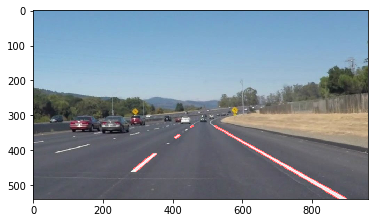

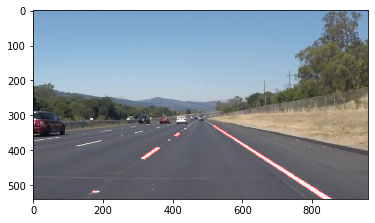

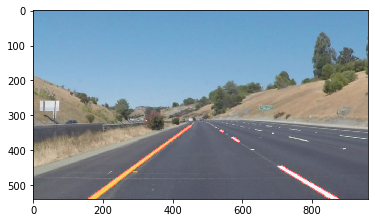

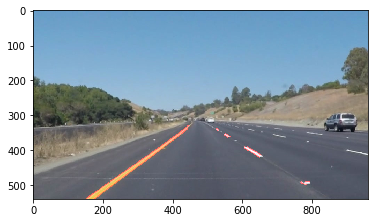

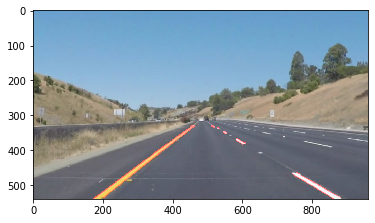

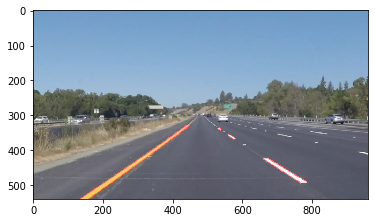

In [14]:
# TODO: The following pipeline draws lane lines on the test_images
# then save them to the test_images_output directory.
# 
#reading in a test image
for file in dirs:
    test_image = mpimg.imread(os.path.join('test_images/',file))
    gray_image = grayscale(test_image)
    kernel_size = 3
    poly_height=330
    poly_bottom_left_x=130
    poly_bottom_right_x=900
    poly_top_left_x=530
    poly_top_right_x=440
    canny_low_threshold=100
    canny_upper_threshold=200
    blur_gray = gaussian_blur(gray_image,kernel_size)
    edge_image = canny(blur_gray, canny_low_threshold, canny_upper_threshold)
    vertices = np.array([[(poly_bottom_left_x,test_image.shape[0]), (poly_bottom_right_x,test_image.shape[0]), (poly_top_left_x,poly_height), (poly_top_right_x,poly_height)]], dtype=np.int32)
    masked_edge_image=region_of_interest(edge_image, vertices)

# Define the Hough  parameters
# Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(masked_edge_image)*0 # creating a blank to draw lines on

# Run Hough on edge detected image
# Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edge_image, rho, theta, threshold, min_line_length, max_line_gap)

# Create a "color" binary image to combine with line image
#color_edges = np.dstack((edge_image, edge_image, edge_image)) 

# Draw the lines on the edge image
    lines_edges = weighted_img(line_image, test_image) 
    concatanate_line_image = concatanate_hough_lines(masked_edge_image, rho, theta, threshold, min_line_length, max_line_gap,poly_height)
    overlayed_concatanate_line_image = weighted_img(concatanate_line_image, test_image, 0.8, 1, 0) 
    cv2.imwrite(os.path.join('test_images_output/',file), cv2.cvtColor(lines_edges, cv2.COLOR_RGB2BGR))
    #cv2.imwrite(os.path.join('test_images_output/concat/',file), cv2.cvtColor(overlayed_concatanate_line_image, cv2.COLOR_RGB2BGR))
#Uncomment below to plot and test out images
#printing out images for testing
    #print('This image is:', type(image), 'with dimensions:', image.shape)
    #plt.imshow(edge_image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')
    #plt.figure()
    #plt.imshow(masked_edge_image)
    plt.figure()
    plt.imshow(lines_edges)
    #plt.figure()
    #plt.imshow(concatanate_line_image)
    #plt.figure()
    #plt.imshow(overlayed_concatanate_line_image)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [21]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_image = grayscale(image)
    kernel_size = 3
    poly_height=330
    poly_bottom_left_x=130
    poly_bottom_right_x=900
    poly_top_left_x=530
    poly_top_right_x=440
    canny_low_threshold=100
    canny_upper_threshold=200
    blur_gray = gaussian_blur(gray_image,kernel_size)
    edge_image = canny(blur_gray, canny_low_threshold, canny_upper_threshold)
    vertices = np.array([[(poly_bottom_left_x,test_image.shape[0]), (poly_bottom_right_x,test_image.shape[0]), (poly_top_left_x,poly_height), (poly_top_right_x,poly_height)]], dtype=np.int32)
    masked_edge_image=region_of_interest(edge_image, vertices)

# Define the Hough  parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(masked_edge_image)*0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edge_image, rho, theta, threshold, min_line_length, max_line_gap)
    # Draw the lines on the edge image
    result = weighted_img(line_image, image, 0.8, 1, 0) 


    return result

# This function processes the videos to overlay solid left and right lines
def process_image_solid_lines(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_image = grayscale(image)
    kernel_size = 3
    poly_height=330
    poly_bottom_left_x=130
    poly_bottom_right_x=900
    poly_top_left_x=530
    poly_top_right_x=440
    canny_low_threshold=100
    canny_upper_threshold=200
    blur_gray = gaussian_blur(gray_image,kernel_size)
    edge_image = canny(blur_gray, canny_low_threshold, canny_upper_threshold)
    vertices = np.array([[(poly_bottom_left_x,test_image.shape[0]), (poly_bottom_right_x,test_image.shape[0]), (poly_top_left_x,poly_height), (poly_top_right_x,poly_height)]], dtype=np.int32)
    masked_edge_image=region_of_interest(edge_image, vertices)

    # Define the Hough  parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments

    concatanate_line_image = concatanate_hough_lines(masked_edge_image, rho, theta, threshold, min_line_length, max_line_gap, poly_height)
    result = weighted_img(concatanate_line_image,image, 0.8, 1, 0) 

    return result

# This function processes the challenge video to overlay solid left and right lines
def process_image_challenge_solid_lines(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    gray_image = grayscale(image)                               
    kernel_size = 3
    poly_height=int((image.shape[0])/2)+80
    offset=150
    poly_bottom_left_x=offset
    poly_bottom_right_x=image.shape[1]-offset+50
    poly_top_left_x=int((image.shape[1]/2) +50)
    poly_top_right_x=int((image.shape[1]/2) -30)
    canny_low_threshold=100
    canny_upper_threshold=200
    blur_gray = gaussian_blur(gray_image,kernel_size)
    edge_image = canny(blur_gray, canny_low_threshold, canny_upper_threshold)
    vertices = np.array([[(poly_bottom_left_x,image.shape[0]-80), (poly_bottom_right_x,image.shape[0]-80), (poly_top_left_x,poly_height), (poly_top_right_x,poly_height)]], dtype=np.int32)
    masked_edge_image=region_of_interest(edge_image, vertices)

# Define the Hough  parameters
    # Make a blank the same size as our image to draw on
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 20     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 5 #minimum number of pixels making up a line
    max_line_gap = 1    # maximum gap in pixels between connectable line segments
    line_image = np.copy(masked_edge_image)*0 # creating a blank to draw lines on
    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    line_image = hough_lines(masked_edge_image, rho, theta, threshold, min_line_length, max_line_gap)
    # Draw the lines on the edge image
    #Comment below for solid concatanated lines
    #result = weighted_img(line_image, image, 0.8, 1, 0) 

    #Uncomment below for solid concatanated lines
    concatanate_line_image = concatanate_hough_lines_challenge(masked_edge_image, rho, theta, threshold, min_line_length, max_line_gap, poly_height)
    result = weighted_img(concatanate_line_image,image, 0.8, 1, 0) 

    

    return result

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4



100%|█████████▉| 681/682 [00:19<00:00, 35.26it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 4min 15s, sys: 6.51 s, total: 4min 21s
Wall time: 19.7 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'test_videos_output/solidWhiteRight_solidLines.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidWhiteRight.mp4')
yellow_clip = clip2.fl_image(process_image_solid_lines)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight_solidLines.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight_solidLines.mp4



100%|█████████▉| 221/222 [00:05<00:00, 38.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight_solidLines.mp4 

CPU times: user 1min 18s, sys: 2.05 s, total: 1min 20s
Wall time: 6.08 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [24]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,3)
#clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image_challenge_solid_lines)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4



 99%|█████████▊| 75/76 [00:02<00:00, 29.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 36.4 s, sys: 1.12 s, total: 37.5 s
Wall time: 2.99 s


In [25]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(challenge_output))